In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import mnist

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

In [6]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input,
# convert them into normal distribution and pass them to the decoder layer

class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

#VAE with Vanilla Architecture

Encoder

In [7]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │        100,368 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super().__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder
		self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
		self.reconstruction_loss_tracker = keras.metrics.Mean(
			name="reconstruction_loss"
		)
		self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

	@property
	def metrics(self):
		return [
			self.total_loss_tracker,
			self.reconstruction_loss_tracker,
			self.kl_loss_tracker,
		]

	def train_step(self, data):
		with tf.GradientTape() as tape:
			mean,log_var, z = self.encoder(data)
			reconstruction = self.decoder(z)
			reconstruction_loss = tf.reduce_mean(
				tf.reduce_sum(
					keras.losses.binary_crossentropy(data, reconstruction),
					axis=(1, 2),
				)
			)
			kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
			kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		self.total_loss_tracker.update_state(total_loss)
		self.reconstruction_loss_tracker.update_state(reconstruction_loss)
		self.kl_loss_tracker.update_state(kl_loss)
		return {
			"loss": self.total_loss_tracker.result(),
			"reconstruction_loss": self.reconstruction_loss_tracker.result(),
			"kl_loss": self.kl_loss_tracker.result(),
		}

In [10]:
vae1 = VAE(encoder, decoder)
vae1.compile(optimizer=keras.optimizers.Adam())
history1 = vae1.fit(mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - kl_loss: 2.4322 - loss: 254.4911 - reconstruction_loss: 252.0589
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 5.6042 - loss: 179.7965 - reconstruction_loss: 174.1922
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 6.1335 - loss: 167.0235 - reconstruction_loss: 160.8900
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 6.4656 - loss: 163.1742 - reconstruction_loss: 156.7086
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 6.5979 - loss: 160.4618 - reconstruction_loss: 153.8639
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl_loss: 6.6977 - loss: 159.1079 - reconstruction_loss: 152.4102
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 6.7476 - loss: 158.2225 - reconstruction_loss: 151.4749
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 6.7327 - loss: 156.9791 - reconstruction_loss: 150.2463
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━

In [11]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
	# display a n*n 2D manifold of images
	img_size = 28
	scale = 0.5
	figure = np.zeros((img_size * n, img_size * n))
	# linearly spaced coordinates corresponding to the 2D plot
	# of images classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			sample = np.array([[xi, yi]])
			x_decoded = vae.decoder.predict(sample, verbose=0)
			images = x_decoded[0].reshape(img_size, img_size)
			figure[
				i * img_size : (i + 1) * img_size,
				j * img_size : (j + 1) * img_size,
			] = images

	plt.figure(figsize=(figsize, figsize))
	start_range = img_size // 2
	end_range = n * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap="Greys_r")
	plt.show()

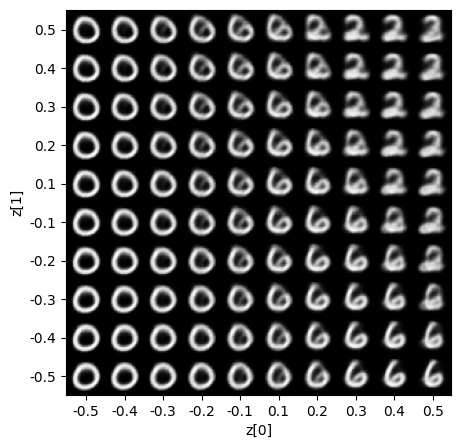

In [12]:
plot_latent_space(vae1)

#Encoder with encoder-decoder architecture

Encoder

In [13]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder2 = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder2")
encoder2.summary()

Model: "encoder2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 14, 14, 128)    │        147,584 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 28, 28, 64)     │         73,792 │ conv2d_transpose_3[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │        100,368 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 507,092 (1.93 MB)

 Trainable params: 507,092 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder2 = keras.Model(latent_inputs, decoder_outputs, name="decoder2")
decoder2.summary()

Model: "decoder2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam())
history2 = vae2.fit(mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - kl_loss: 1.0248e-04 - loss: 257.1688 - reconstruction_loss: 257.1687
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 6.3867e-04 - loss: 206.6097 - reconstruction_loss: 206.6091
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 0.0012 - loss: 206.5665 - reconstruction_loss: 206.5653
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - kl_loss: 0.0017 - loss: 206.3371 - reconstruction_loss: 206.3354
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 0.0020 - loss: 205.8500 - reconstruction_loss: 205.8479
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - kl_loss: 0.0021 - loss: 206.1176 - reconstruction_loss: 206.1154
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - kl_loss: 0.0020 - loss: 206.1808 - reconstruction_loss: 206.1788
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - kl_loss: 0.0017 - loss: 206.2239 - reconstruction_loss: 206.2223
Epoch 9/10
547/547 ━━━━━

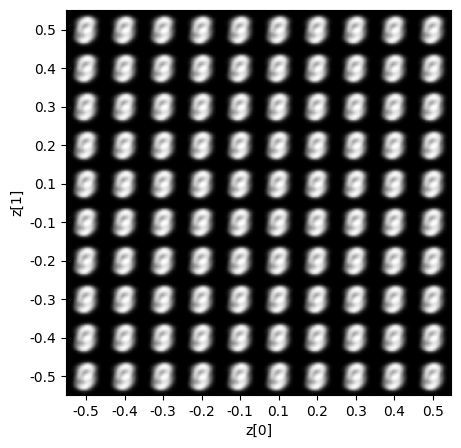

In [16]:
plot_latent_space(vae2)

#Decoder with encoder-decoder architecture

Encoder

In [17]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder3 = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder3")
encoder3.summary()

Model: "encoder3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 64)     │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 6272)           │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │        100,368 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [18]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder3 = keras.Model(latent_inputs, decoder_outputs, name="decoder3")
decoder3.summary()

Model: "decoder3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,793 (1.87 MB)

 Trainable params: 489,793 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
vae3 = VAE(encoder3, decoder3)
vae3.compile(optimizer=keras.optimizers.Adam())
history3 = vae3.fit(mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - kl_loss: 1.4332 - loss: 244.5387 - reconstruction_loss: 243.1054
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - kl_loss: 6.0552 - loss: 174.3201 - reconstruction_loss: 168.2650
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - kl_loss: 6.7448 - loss: 160.8331 - reconstruction_loss: 154.0883
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - kl_loss: 6.8739 - loss: 157.6423 - reconstruction_loss: 150.7683
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - kl_loss: 6.9619 - loss: 155.4716 - reconstruction_loss: 148.5096
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - kl_loss: 6.9873 - loss: 154.6385 - reconstruction_loss: 147.6512
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - kl_loss: 7.0322 - loss: 153.4823 - reconstruction_loss: 146.4501
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - kl_loss: 7.0659 - loss: 152.7577 - reconstruction_loss: 145.6918
Epoch 9/10
547/547 ━━━━━━━━━━━━━

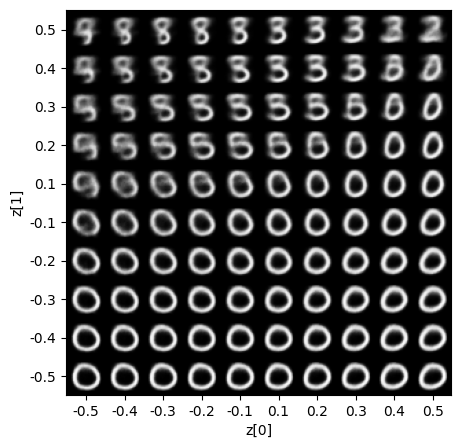

In [20]:
plot_latent_space(vae3)

#Both are replaced with encoder-decoder architecture

Encoder

In [21]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder4 = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder4")
encoder4.summary()

Model: "encoder4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 14, 14, 64)     │            640 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_13       │ (None, 14, 14, 128)    │        147,584 │ conv2d_11[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_14       │ (None, 28, 28, 64)     │         73,792 │ conv2d_transpose_13[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_transpose_14[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 6272)           │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 16)             │        100,368 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_3 (Sampling)     │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 507,092 (1.93 MB)

 Trainable params: 507,092 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [22]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder4 = keras.Model(latent_inputs, decoder_outputs, name="decoder4")
decoder4.summary()

Model: "decoder4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 14, 14, 128)         │          73,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 28, 28, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 14, 14, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 28, 28, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,793 (1.87 MB)

 Trainable params: 489,793 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
vae4 = VAE(encoder4, decoder4)
vae4.compile(optimizer=keras.optimizers.Adam())
history4 = vae4.fit(mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - kl_loss: 0.3330 - loss: 249.5679 - reconstruction_loss: 249.2350
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - kl_loss: 8.2449e-04 - loss: 206.6547 - reconstruction_loss: 206.6538
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - kl_loss: 0.0013 - loss: 206.5704 - reconstruction_loss: 206.5691
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - kl_loss: 0.0012 - loss: 206.6362 - reconstruction_loss: 206.6350
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - kl_loss: 9.7285e-04 - loss: 206.4555 - reconstruction_loss: 206.4546
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - kl_loss: 7.7789e-04 - loss: 206.2041 - reconstruction_loss: 206.2034
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - kl_loss: 6.0864e-04 - loss: 206.0519 - reconstruction_loss: 206.0513
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - kl_loss: 4.7307e-04 - loss: 206.1863 - reconstruction_loss: 206.1858
Epoch 9/10
5

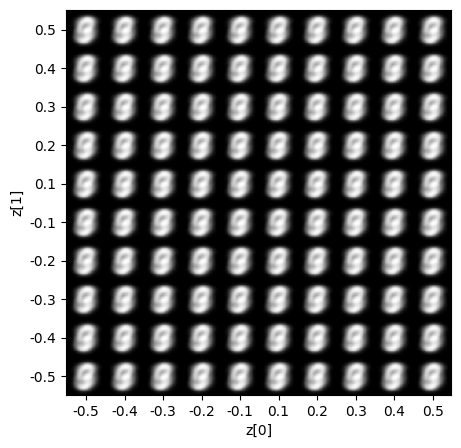

In [24]:
plot_latent_space(vae4)

## Comapring histories

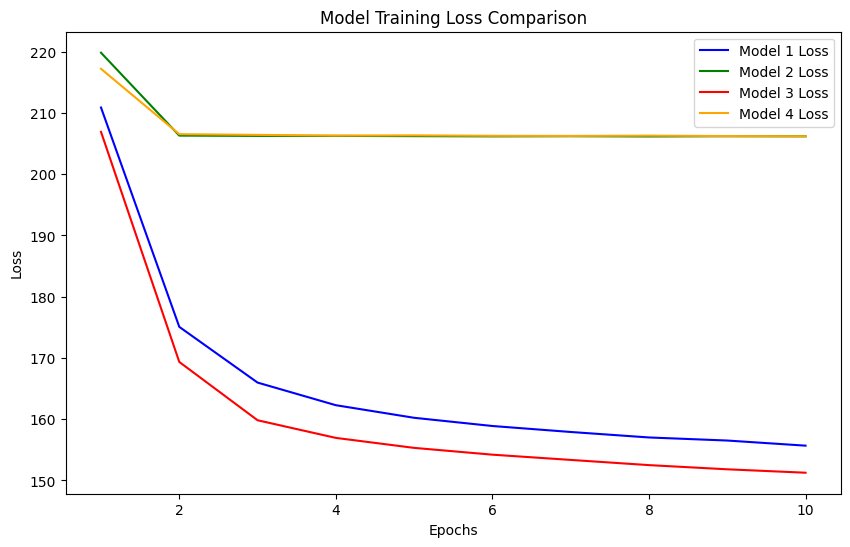

In [25]:
# Extract the loss (or other metric) for each model
loss_1 = history1.history['loss']
loss_2 = history2.history['loss']
loss_3 = history3.history['loss']
loss_4 = history4.history['loss']

# Define the number of epochs
epochs = range(1, len(loss_1) + 1)

# Plotting the loss for each model
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_1, label="Model 1 Loss", color='blue')
plt.plot(epochs, loss_2, label="Model 2 Loss", color='green')
plt.plot(epochs, loss_3, label="Model 3 Loss", color='red')
plt.plot(epochs, loss_4, label="Model 4 Loss", color='orange')

# Adding labels and title
plt.title("Model Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plot
plt.show()

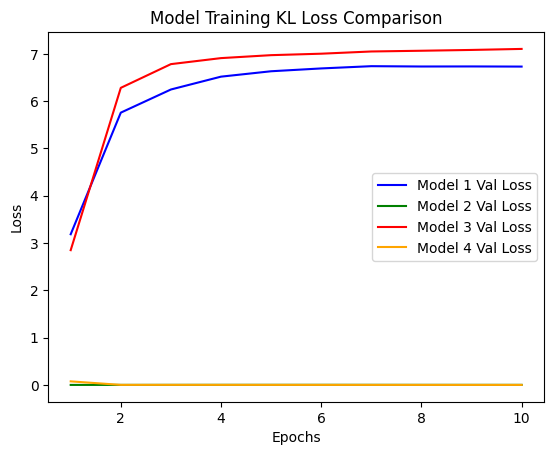

In [26]:
kl_loss_1 = history1.history['kl_loss']
kl_loss_2 = history2.history['kl_loss']
kl_loss_3 = history3.history['kl_loss']
kl_loss_4 = history4.history['kl_loss']

# Define the number of epochs
epochs = range(1, len(kl_loss_1) + 1)

plt.plot(epochs, kl_loss_1, label="Model 1 Val Loss", color='blue')
plt.plot(epochs, kl_loss_2, label="Model 2 Val Loss", color='green')
plt.plot(epochs, kl_loss_3, label="Model 3 Val Loss", color='red')
plt.plot(epochs, kl_loss_4, label="Model 4 Val Loss", color='orange')

# Adding labels and title
plt.title("Model Training KL Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plot
plt.show()

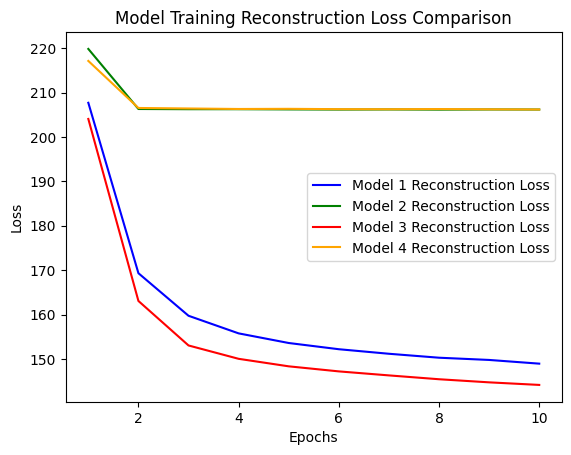

In [27]:
rec_loss_1 = history1.history['reconstruction_loss']
rec_loss_2 = history2.history['reconstruction_loss']
rec_loss_3 = history3.history['reconstruction_loss']
rec_loss_4 = history4.history['reconstruction_loss']

# Define the number of epochs
epochs = range(1, len(rec_loss_1) + 1)

plt.plot(epochs, rec_loss_1, label="Model 1 Reconstruction Loss", color='blue')
plt.plot(epochs, rec_loss_2, label="Model 2 Reconstruction Loss", color='green')
plt.plot(epochs, rec_loss_3, label="Model 3 Reconstruction Loss", color='red')
plt.plot(epochs, rec_loss_4, label="Model 4 Reconstruction Loss", color='orange')

# Adding labels and title
plt.title("Model Training Reconstruction Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plot
plt.show()

\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Loss (Last Epoch)} & \textbf{KL Loss (Last Epoch)} & \textbf{Reconstruction Loss (Last Epoch)} \\
\hline
\text{Model 1} & \text{155.8742} & \text{6.7295} & \text{149.1447} \\
\text{Model 2} & \text{206.3853} & \text{0.0012} & \text{206.3842} \\
\text{Model 3} & \text{151.5172} & \text{7.1049} & \text{144.4123} \\
\text{Model 4} & \text{206.0128} & \text{2.2549e-04} & \text{206.0126} \\
\hline
\end{array}



## Model Performance Comparison

We observe that **Model 1 (Vanilla VAE)** and **Model 3 (Decoder with Encoder-Decoder Architecture)** perform almost similarly, with **Model 3 being slightly better**.  

However, **Model 4 (Both Encoder & Decoder replaced with Encoder-Decoder Architecture)** and **Model 2 (Encoder with Encoder-Decoder Architecture)** show the **worst performance**.  

### **Key Observation:**
- **Reconstruction Loss** is the major contributor to the overall loss.  
- **Optimizing the decoder** plays a **crucial role** in improving model performance.
